In [18]:
import os
import random
import torch
from nnfabrik.builder import get_data

import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt

from csng.utils import crop
from csng.mouse_v1.cnn_decoder_utils import get_all_data

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

DATA_PATH='/home/sobotj11/decoding-brain-activity/data/mouse_v1_sensorium22'


In [7]:
config = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
}

print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [8]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [20]:
config["crop_win"] = (22, 36)
config["data"] = dict(mixing_strategy="sequential")

### mouse v1 data
config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            # os.path.join(DATA_PATH, "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # mouse 1
            # os.path.join(DATA_PATH, "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # sensorium+ (mouse 2)
            os.path.join(DATA_PATH, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 3)
            # os.path.join(DATA_PATH, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 4)
            # os.path.join(DATA_PATH, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 5)
            # os.path.join(DATA_PATH, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 6)
            # os.path.join(DATA_PATH, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 7)
        ],
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 8,
        "seed": config["seed"],
        "use_cache": False,
    },
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

### synthetic data config
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        # "23964-4-22",
    ],
    "batch_size": 8,
    "responses_shift_mean": True,
    "responses_clip_min": None,
    "responses_clip_max": None,
    "append_data_parts": ["train"],
    "data_key_prefix": None, # the same data key as the original (real) data
    "dir_name": "synthetic_data_mouse_v1_encoder_new_stimuli",
    "device": config["device"],
}

dls, neuron_coords = get_all_data(config=config)

Training dataset:	 54480 samples
Validation dataset:	 528 samples
Test dataset:		 105 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([7, 1, 36, 64])
  min=-1.750  max=2.225
  mean=0.093  std=0.944
responses:
  torch.Size([7, 8372])
  min=0.000  max=12.693
  mean=0.290  std=0.544
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


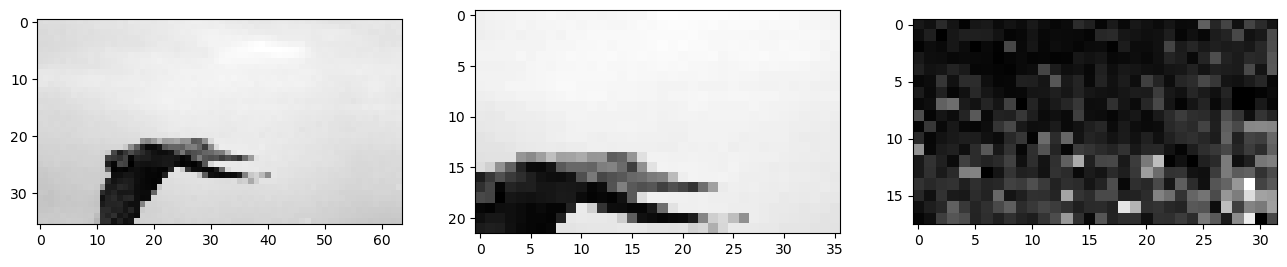

In [21]:
### show data
sample_data_key = dls["mouse_v1"]["test"].data_keys[0]
datapoint = next(iter(dls["mouse_v1"]["test"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dls['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

Training dataset:	 54480 samples
Validation dataset:	 528 samples
Test dataset:		 105 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([8, 1, 36, 64])
  min=-1.750  max=2.198
  mean=0.106  std=0.786
responses:
  torch.Size([8, 8372])
  min=-1.295  max=12.561
  mean=0.176  std=0.857
Neuron coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593
Pupil center:
  torch.Size([8, 2])
  min=-0.238  max=0.776
  mean=0.218  std=0.377


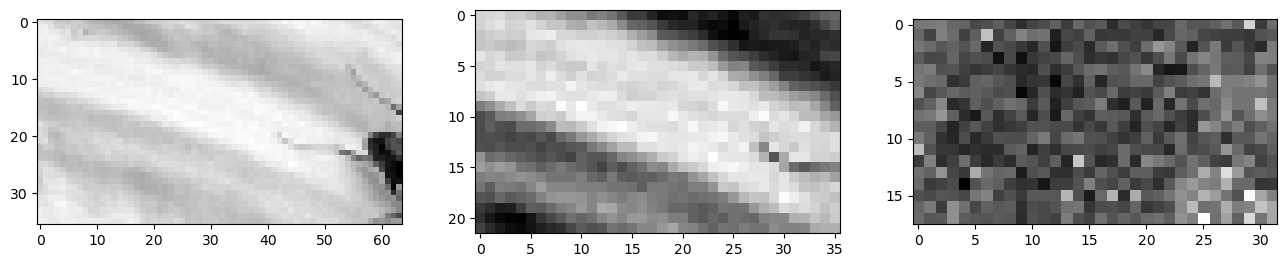

In [22]:
### show synthetic data
syn_stim, syn_resp, syn_pupil_center = next(iter(dls["mouse_v1"]["train"].dataloaders[-1]))
syn_sample_data_key = dls["mouse_v1"]["train"].data_keys[-1]
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dls['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {syn_stim.shape}"
    f"\n  min={syn_stim.min().item():.3f}  max={syn_stim.max().item():.3f}"
    f"\n  mean={syn_stim.mean().item():.3f}  std={syn_stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {syn_resp.shape}"
    f"\n  min={syn_resp.min().item():.3f}  max={syn_resp.max().item():.3f}"
    f"\n  mean={syn_resp.mean().item():.3f}  std={syn_resp.std().item():.3f}"
    "\nNeuron coordinates:"
    f"\n  {neuron_coords[syn_sample_data_key].shape}"
    f"\n  min={neuron_coords[syn_sample_data_key].min():.3f}  max={neuron_coords[syn_sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[syn_sample_data_key].mean():.3f}  std={neuron_coords[syn_sample_data_key].std():.3f}"
    "\nPupil center:"
    f"\n  {syn_pupil_center.shape}"
    f"\n  min={syn_pupil_center.min().item():.3f}  max={syn_pupil_center.max().item():.3f}"
    f"\n  mean={syn_pupil_center.mean().item():.3f}  std={syn_pupil_center.std().item():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(syn_stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[syn_sample_data_key]
H, W = syn_stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_x_bins):
    for j in range(n_y_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[i] <= coords[:,0]) &\
               (coords[:,0] < x_bins[i + 1]) &\
               (y_bins[j] <= coords[:,1]) &\
               (coords[:,1] < y_bins[j + 1])
        binned_resp[j,i] = syn_resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

## Get statistics of data

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
import wandb
from nnfabrik.builder import get_data

import csng
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import RunningStats, crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, plot_losses
from csng.losses import SSIMLoss, MSELossWithCrop, Loss
from csng.data import MixedBatchLoader
from csng.readins import (
    MultiReadIn,
    HypernetReadIn,
    ConvReadIn,
    AttentionReadIn,
    FCReadIn,
    AutoEncoderReadIn,
    Conv1dReadIn,
    LocalizedFCReadIn,
)

from data_utils import (
    get_mouse_v1_data,
    append_syn_dataloaders,
    append_data_aug_dataloaders,
    RespGaussianNoise,
)

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

%env "WANDB_NOTEBOOK_NAME" "cnn_decoder.ipynb"
wandb.login()

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'
env: "WANDB_NOTEBOOK_NAME"="cnn_decoder.ipynb"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnny1188. Use `wandb login --relogin` to force relogin


True

In [3]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    # "crop_win": None,
    # "crop_win": (slice(7, 29), slice(15, 51)),
    "crop_win": (22, 36),
    "wandb": None,
    # "wandb": {
    #     "project": "CSNG",
    #     "group": "sensorium_2022",
    # },
}
print(f"... Running on {config['device']} ...")
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

... Running on cuda ...


In [4]:
dataloaders = dict()
config["data"]["mouse_v1"] = None
config["data"]["syn_dataset_config"] = None
config["data"]["data_augmentation"] = None

In [5]:
### prep data config
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    # "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    # "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    # "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    # "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    # "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    # "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"]["mouse_v1"] = {
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        "batch_size": 16,
        # "batch_size": 7,
        "seed": config["seed"],
        "use_cache": False,
    },
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

In [6]:
### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config["data"])

Training dataset:	 4480 samples
Validation dataset:	 528 samples
Test dataset:		 240 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([7, 1, 36, 64])
  min=-1.750  max=2.225
  mean=0.093  std=0.944
responses:
  torch.Size([7, 8372])
  min=0.000  max=12.693
  mean=0.290  std=0.544
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


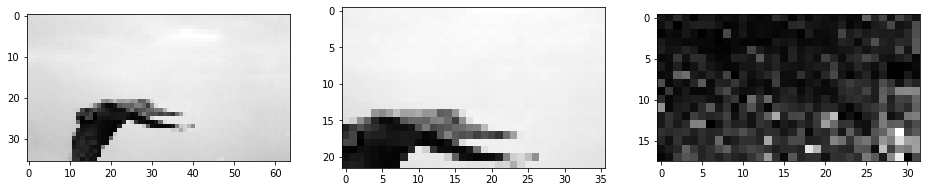

In [8]:
### show data
sample_data_key = dataloaders["mouse_v1"]["test"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["test"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

In [77]:
dps = []
tiers = dataloaders["mouse_v1"]["train"].datasets[1].trial_info.tiers
for i, datapoint in enumerate(dataloaders["mouse_v1"]["train"].datasets[0]):
    if tiers[i] != "train":
        continue
    dps.append(datapoint.responses.unsqueeze(0))
dps = torch.cat(dps, dim=0)
dps.shape

torch.Size([4490, 8098])

In [79]:
iqr = torch.quantile(dps, 0.75, dim=0) - torch.quantile(dps, 0.25, dim=0)
mean = dps.mean(dim=0)
med = torch.median(dps, dim=0).values
iqr, mean, med

(tensor[8098] x∈[8.434e-10, 1.443] μ=0.216 σ=0.184,
 tensor[8098] x∈[0.127, 1.011] μ=0.315 σ=0.092,
 tensor[8098] x∈[1.808e-10, 0.852] μ=0.007 σ=0.046)

In [80]:
if not os.path.exists(os.path.join(DATA_PATH, dataloaders["mouse_v1"]["train"].datasets[0].dirname, "stats")):
    os.makedirs(os.path.join(DATA_PATH, dataloaders["mouse_v1"]["train"].datasets[0].dirname, "stats"))
else:
    print("[WARNING] stats directory already exists")

In [81]:
np.save(
    os.path.join(
        DATA_PATH,
        dataloaders["mouse_v1"]["train"].datasets[0].dirname,
        "stats",
        f"responses_iqr.npy"
    ),
    iqr.cpu().numpy(),
)
np.save(
    os.path.join(
        DATA_PATH,
        dataloaders["mouse_v1"]["train"].datasets[0].dirname,
        "stats",
        f"responses_mean.npy"
    ),
    mean.cpu().numpy(),
)
np.save(
    os.path.join(
        DATA_PATH,
        dataloaders["mouse_v1"]["train"].datasets[0].dirname,
        "stats",
        f"responses_med.npy"
    ),
    med.cpu().numpy(),
)

### The same but for synthetic data

In [31]:
### append synthetic data
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        # "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        "23964-4-22",
    ],
    "batch_size": 32,
    "append_data_parts": ["train"],
    # "data_key_prefix": "syn",
    "data_key_prefix": None, # the same data key as the original (real) data
}

dataloaders = append_syn_dataloaders(dataloaders, config=config["data"]["syn_dataset_config"])

In [32]:
dataloaders["mouse_v1"]["train"].datasets

[FileTreeDataset /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6 (n=5994 items)
 	images, responses, pupil_center,

In [33]:
dps = []
for i, datapoint in enumerate(dataloaders["mouse_v1"]["train"].datasets[-1]):
    dps.append(datapoint.responses.unsqueeze(0))
dps = torch.cat(dps, dim=0)
dps.shape

torch.Size([4490, 8098])

In [34]:
iqr = torch.quantile(dps, 0.75, dim=0) - torch.quantile(dps, 0.25, dim=0)
mean = dps.mean(dim=0)
med = torch.median(dps, dim=0).values
iqr, mean, med

(tensor[8098] x∈[0.233, 1.463] μ=0.864 σ=0.221,
 tensor[8098] x∈[0.127, 1.009] μ=0.315 σ=0.094,
 tensor[8098] x∈[-0.187, 0.932] μ=0.016 σ=0.119)

In [35]:
if not os.path.exists(os.path.join(DATA_PATH, dataloaders["mouse_v1"]["train"].datasets[-1].dirname, "stats")):
    os.makedirs(os.path.join(DATA_PATH, dataloaders["mouse_v1"]["train"].datasets[-1].dirname, "stats"))
else:
    print("[WARNING] stats directory already exists")

[WARNING] stats directory already exists


In [36]:
np.save(
    os.path.join(
        DATA_PATH,
        dataloaders["mouse_v1"]["train"].datasets[-1].dirname,
        "stats",
        f"responses_iqr.npy"
    ),
    iqr.cpu().numpy(),
)
np.save(
    os.path.join(
        DATA_PATH,
        dataloaders["mouse_v1"]["train"].datasets[-1].dirname,
        "stats",
        f"responses_mean.npy"
    ),
    mean.cpu().numpy(),
)
np.save(
    os.path.join(
        DATA_PATH,
        dataloaders["mouse_v1"]["train"].datasets[-1].dirname,
        "stats",
        f"responses_med.npy"
    ),
    med.cpu().numpy(),
)